# #1

This [dataset](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset/data)  is related to red variants of the Portuguese "Vinho Verde" wine. The dataset describes the amount of various chemicals present in wine and their effect on it's quality.

### Loading packages

In [131]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns


In [132]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [133]:
sns.set_palette("dark", n_colors=12)

## Exploratory Data Analysis

In [134]:
df = pd.read_csv("WineQT.csv")
df.drop("Id", inplace=True, axis=1) # removing the redundant ID column (same as index of the df)
print(len(df))
df.head()

1143


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

Here, we have 11 features (columns 1-11), all of which are numerical. Our study variable is _quality_ which can take scores: 0-10. 

### Missing values?

In [135]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

No missing values in any column.

### Duplicates?

In [136]:
df.duplicated().sum()

125

Dropping duplicates:

In [137]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
len(df)

1018

In [138]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.66         0.00             1.8      0.075   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 13.0                  40.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

### Checking for balanced classes

In [139]:
from collections import Counter 

freq = [(key, val) for key, val in Counter(df.quality).items()]
repr = pd.DataFrame(freq, columns=["wine quality", "frequency"]).sort_values(by="wine quality").reset_index(drop=True)
repr

wine quality  frequency
0             3          6
1             4         33
2             5        433
3             6        409
4             7        122
5             8         15

Adding Zeros for inexistent classes:

In [140]:
full_picture = pd.concat([repr, pd.DataFrame([(0,0), (1,0), (2,0), (9,0), (10,0)], columns=repr.columns)], axis=0).sort_values(by="wine quality").reset_index(drop=True)
full_picture

wine quality  frequency
0              0          0
1              1          0
2              2          0
3              3          6
4              4         33
5              5        433
6              6        409
7              7        122
8              8         15
9              9          0
10            10          0

Text(0, 0.5, 'Frequency')

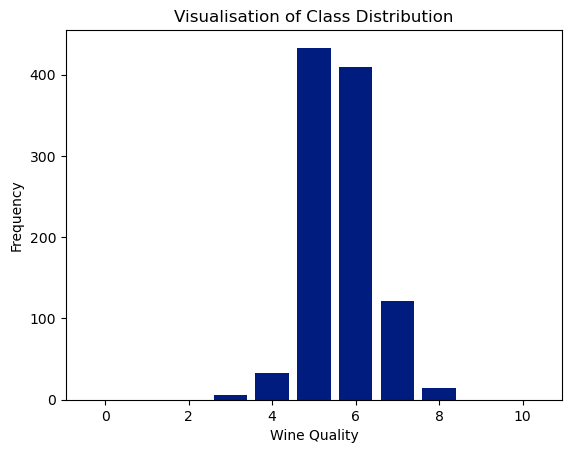

In [141]:
plt.figure()
plt.bar(full_picture["wine quality"], full_picture["frequency"])
plt.title("Visualisation of Class Distribution", )
plt.xlabel("Wine Quality")
plt.ylabel("Frequency")

Clearly, there is immense imbalance in the classes: there exist many more instances of mediocre/average quality red wine than extremely good or extremely bad. In fact, there do not exist any records for wine quality being 0, 1, 2, 9, 10. For accurate models, we will have to restrict our class range to 3-8 and then rename as 0-5. Since we do not have data for the extreme classes, we cannot expect our models to reliably make a guess on this unseen data as it breaks the fundamental assumption of machine learning: the training set is from the same distribution as the test data. 
However, for a Naive Bayes' classifier, we can pad the probabilities of these missing classes (Laplace/Lindstone smoothing).

### Pairwise distributions of features for each target class

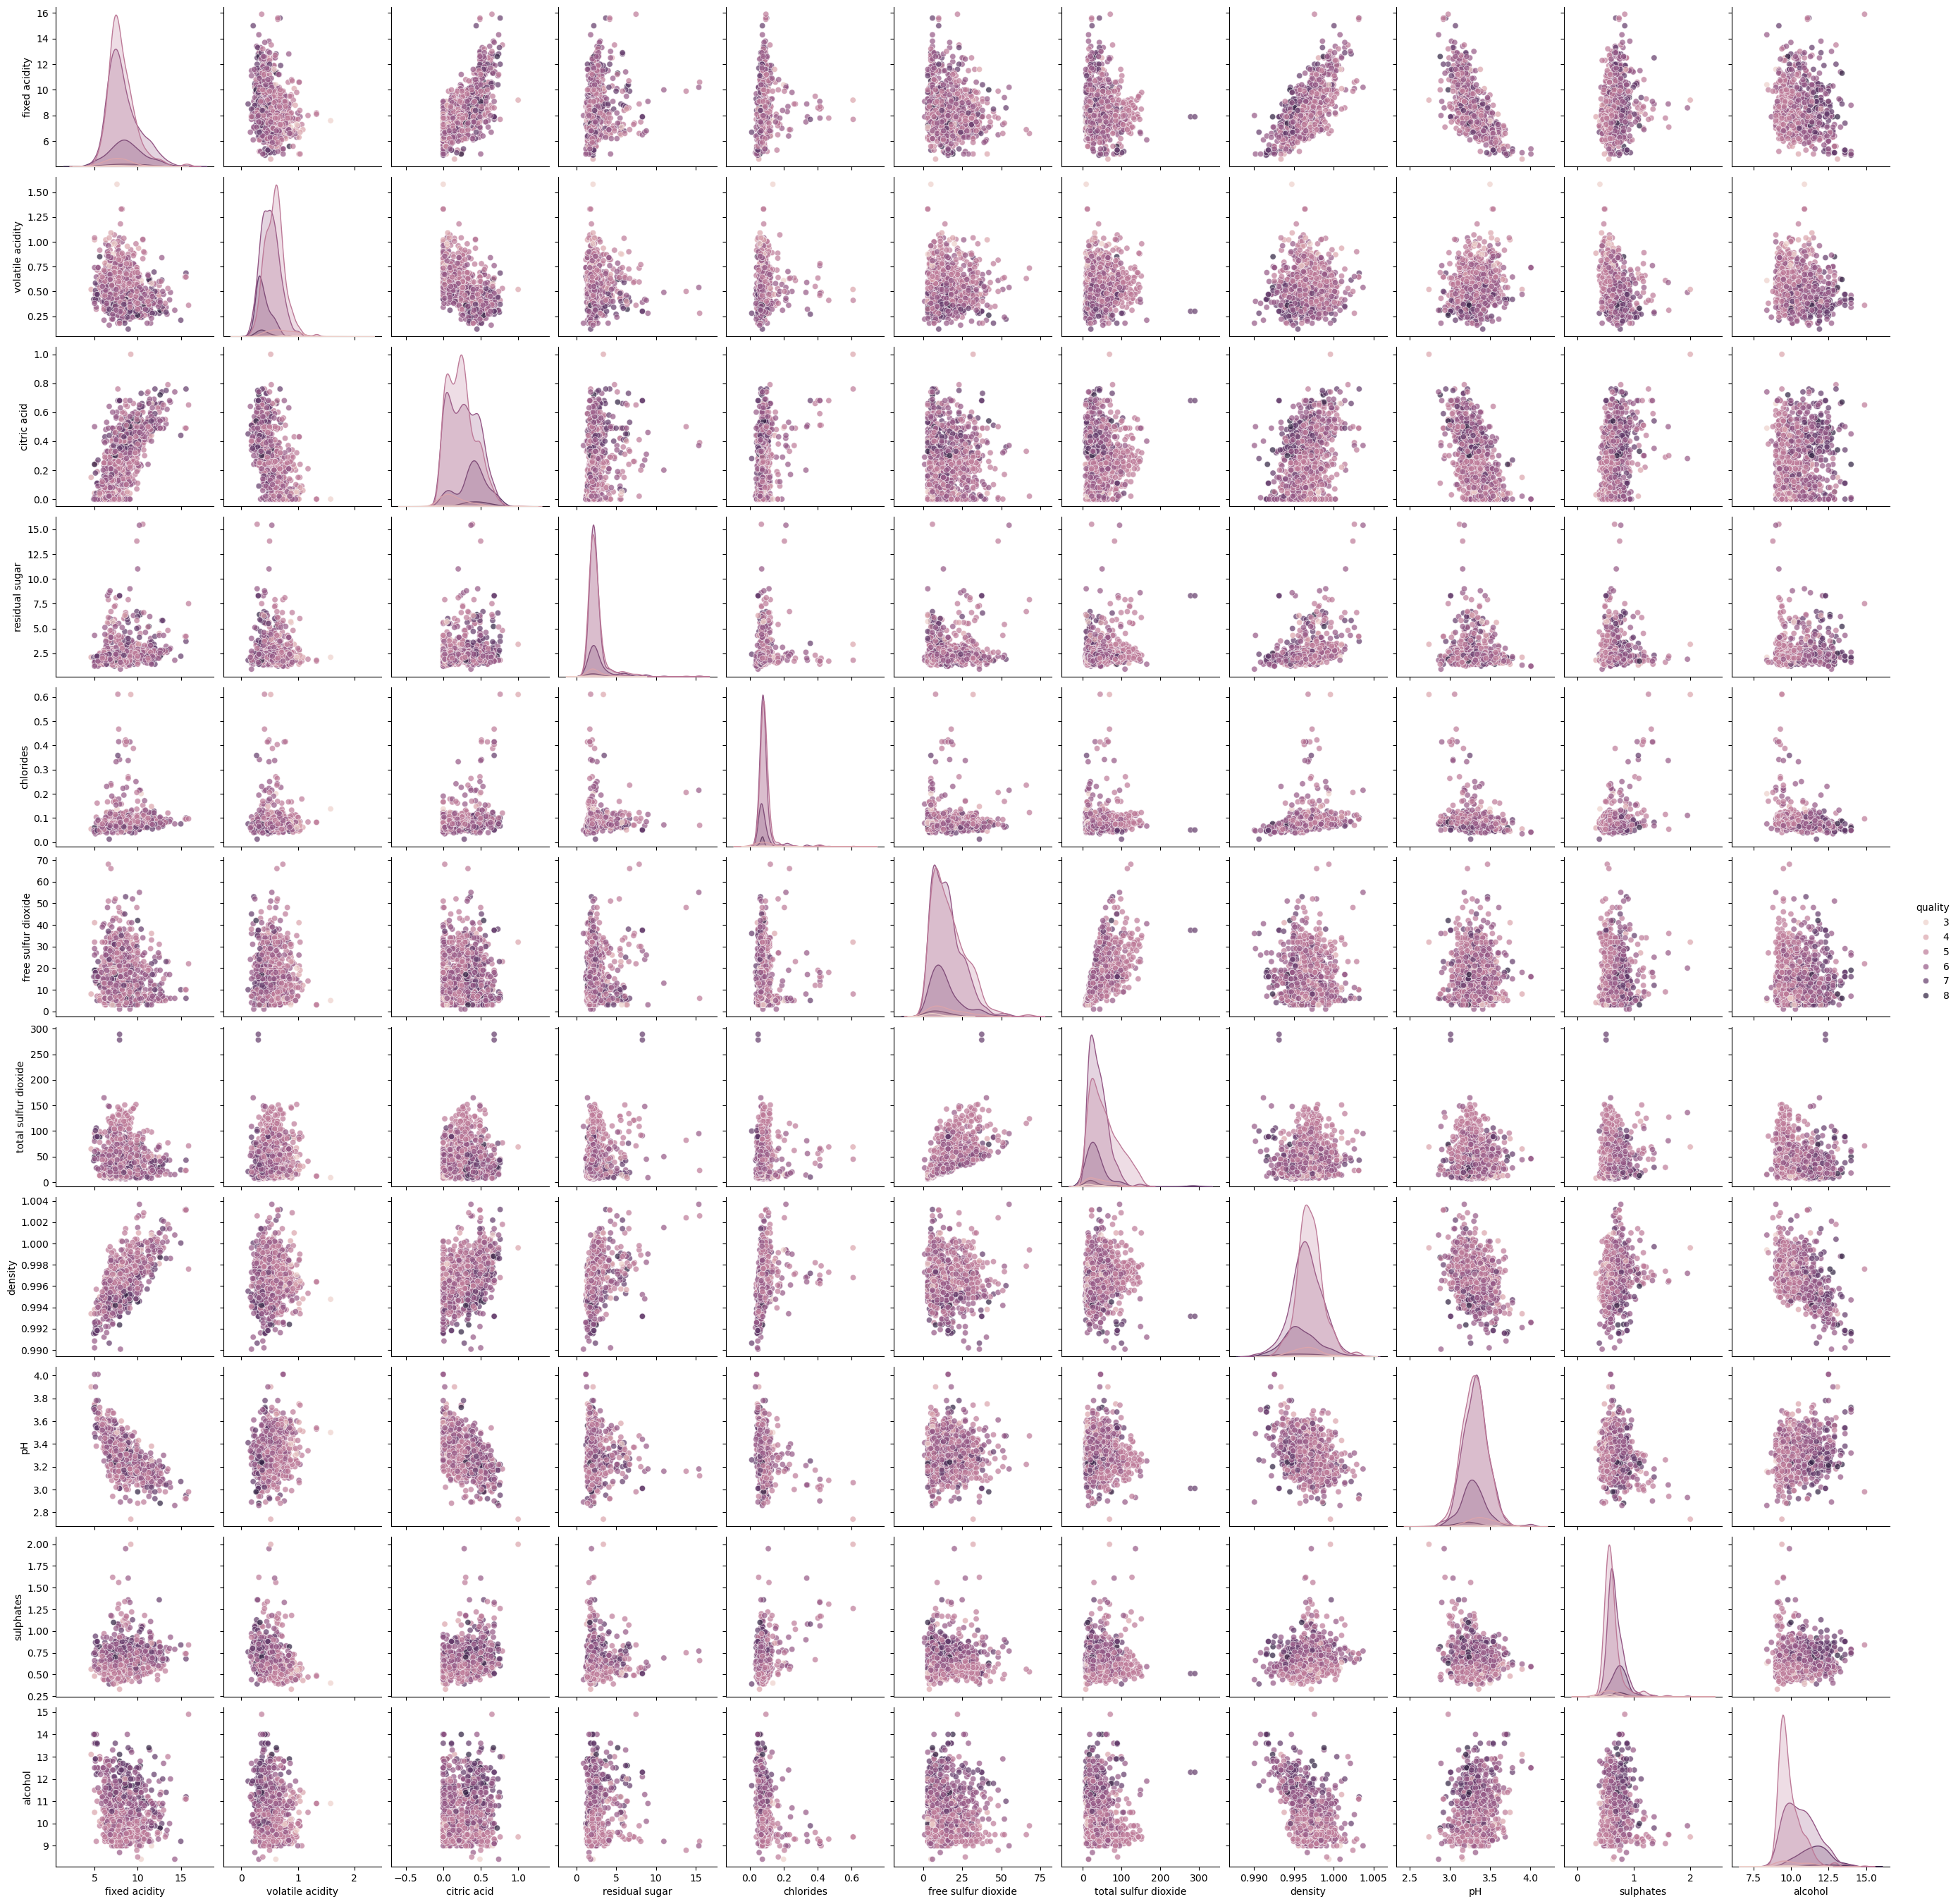

In [142]:
sns.pairplot(df, hue="quality", plot_kws={'alpha': 0.7})

### Checking Correlations between features

Text(0.5, 1.0, 'Correlation Matrix')

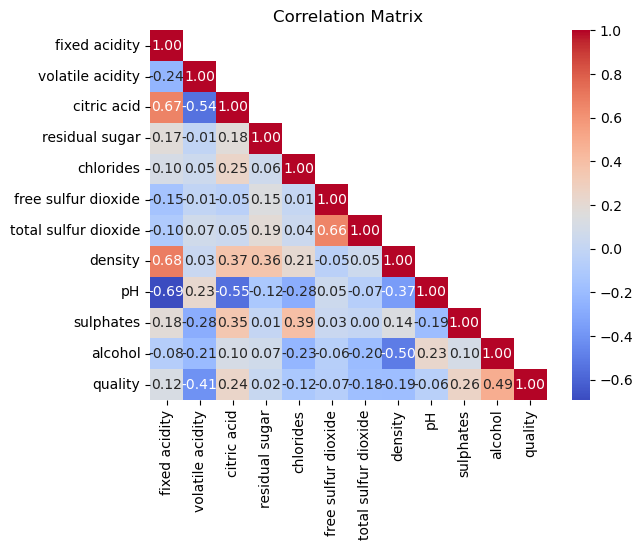

In [143]:
cor_matrix = df.corr()
# cor_matrix.round(2)
mask = np.tril(np.ones_like(cor_matrix, dtype=bool))
sns.heatmap(cor_matrix, mask=~mask, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")

Finding pairs of correlated features:


In [144]:
threshold = 0.7
corr_pairs = (
    cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr = corr_pairs[abs(corr_pairs['Correlation']) >= threshold]
high_corr

Empty DataFrame
Columns: [Feature 1, Feature 2, Correlation]
Index: []

In [145]:
threshold2 = 0.5
med_corr = corr_pairs[abs(corr_pairs['Correlation']) >= threshold2].reset_index(drop=True)
med_corr

Feature 1             Feature 2  Correlation
0        fixed acidity           citric acid     0.668178
1        fixed acidity               density     0.683120
2        fixed acidity                    pH    -0.692597
3     volatile acidity           citric acid    -0.542459
4          citric acid                    pH    -0.553370
5  free sulfur dioxide  total sulfur dioxide     0.661089
6              density               alcohol    -0.504748

- For linear models: logistic regression, SVM, we must perform some sort of feature selection for interpretability. 
- For the Naive Bayes' model, we must drop features with high intercorrelatiion as it violates the Naive independence assumption.
- For neural networks, we must use appropriate regularisation to tackle this issue.
- Tree based methods generally perform a sort of feature selection internally and should perform well even with correlated features.

### Feature distributions

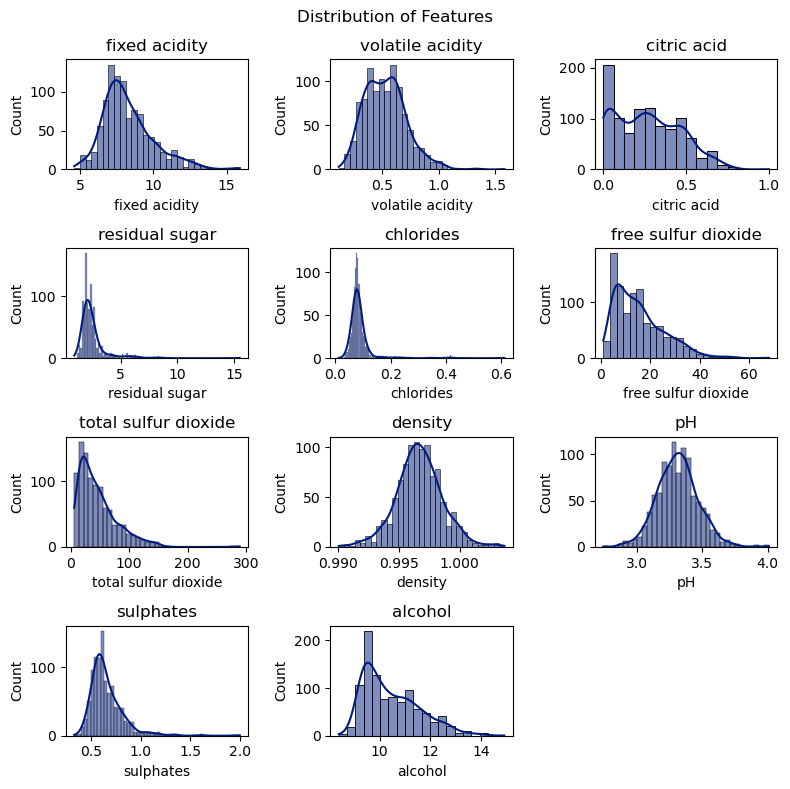

In [146]:
features = df.columns[:-1]  # all columns except quality
fig, axes = plt.subplots(4, 3, figsize=(8, 8))
fig.suptitle('Distribution of Features')

for idx, feature in enumerate(features):
    row = idx // 3
    col = idx % 3
    sns.histplot(data=df, x=feature, kde=True, ax=axes[row, col])
    axes[row, col].set_title(feature)

for idx in range(len(features), len(axes.flatten())):
    axes.flatten()[idx].set_visible(False)
    
plt.tight_layout()


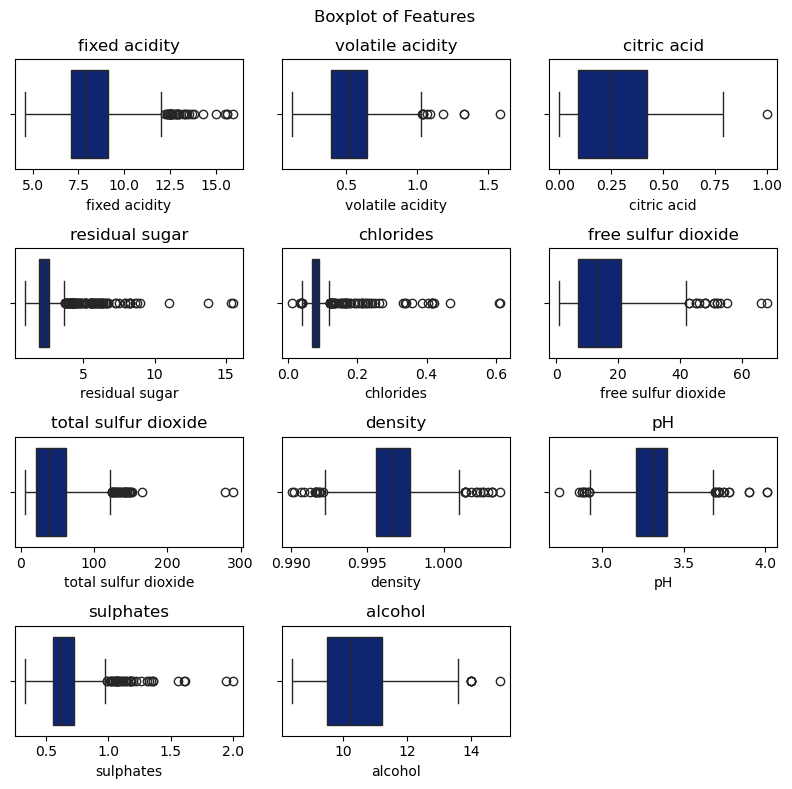

In [147]:
fig, axes = plt.subplots(4, 3, figsize=(8, 8))
fig.suptitle('Boxplot of Features')

for idx, feature in enumerate(features):
    row = idx // 3
    col = idx % 3
    sns.boxplot(data=df[feature], orient='h', ax=axes[row, col])
    axes[row, col].set_title(feature)

for idx in range(len(features), len(axes.flatten())):
    axes.flatten()[idx].set_visible(False)

plt.tight_layout()

Some features seem to have a bell shape: density and pH, while most plots indicate positive skew with outliers present. In particular, _residual sugar_ and _chlorides_ seem to have big outliers.

## Pre-Processing

### Converting classes
Range of classes is now 0-5 from 3-8

In [148]:
y = df["quality"]
y = map(lambda x: x-3, y)
df["quality"] = pd.Series(y)

df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.66         0.00             1.8      0.075   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 13.0                  40.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        2  
1      9.8        2  
2      9.8        2  
3      9.8        3  
4      9.4        2

Tree-based models do not in general require scaling of features. Thus, for those models, we can use our data as is, and just split it for training and testing. 

For all other models, we will scale the features: Standard scaling for features with bell shaped distributions and Robust scaling for the rest.

For models like Logistic Regression, SVM, KNN and Naive Bayes', we will compare model performance with and without feature selection via PCA.

In [149]:
df.to_csv("TreeModelDataset.csv", index=False) # the dataset to use for Tree based classifiers

### Normalising features

In [150]:
df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [151]:
np.min(df.density), np.max(df.density)

(0.99007, 1.00369)

In [152]:
df[df.columns[:-1]].head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.66         0.00             1.8      0.075   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 13.0                  40.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4

In [153]:
rbscaler = RobustScaler()

X = df[df.columns[:-1]]
X = pd.DataFrame(rbscaler.fit_transform(X), columns=df.columns[:-1])

df_nn = pd.concat([X, pd.DataFrame(df["quality"])], axis=1)
df_nn.head(10) # this is the dataset we will use for the neural network


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0          -0.25          0.705882    -0.757576       -0.428571      -0.15   
1          -0.05          1.411765    -0.757576        0.571429       0.95   
2          -0.05          0.941176    -0.636364        0.142857       0.65   
3           1.65         -0.941176     0.939394       -0.428571      -0.20   
4          -0.25          0.549020    -0.757576       -0.571429      -0.20   
5           0.00          0.313725    -0.575758       -0.857143      -0.50   
6          -0.30          0.509804    -0.757576       -1.428571      -0.70   
7          -0.05          0.235294    -0.696970       -0.285714      -0.30   
8          -0.60          0.235294    -0.515152       -0.571429       0.90   
9          -1.15          0.372549    -0.757576       -0.857143       0.50   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.142857             -0.097561  0.503326  1.052632  -0.352941   
1             0.857143              0.707317  0.059867 -0.578947   0.352941   
2             0.142857              0.390244  0.148559 -0.263158   0.176471   
3             0.285714              0.536585  0.592018 -0.789474  -0.235294   
4             0.000000              0.048780  0.503326  1.052632  -0.352941   
5             0.142857              0.512195 -0.117517 -0.052632  -0.941176   
6             0.142857             -0.414634 -0.915743  0.421053  -0.882353   
7            -0.285714             -0.487805  0.059867  0.263158  -0.294118   
8             0.142857              0.658537 -0.339246 -0.157895  -0.470588   
9             0.214286              0.512195 -1.048780  1.421053  -0.588235   

    alcohol  quality  
0 -0.470588        2  
1 -0.235294        2  
2 -0.235294        2  
3 -0.235294        3  
4 -0.470588        2  
5 -0.470588        2  
6 -0.117647        4  
7 -0.411765        4  
8 -0.588235        2  
9 -0.176471        2

In [154]:
df_nn.to_csv("NNDataset.csv", index=False)

### PCA

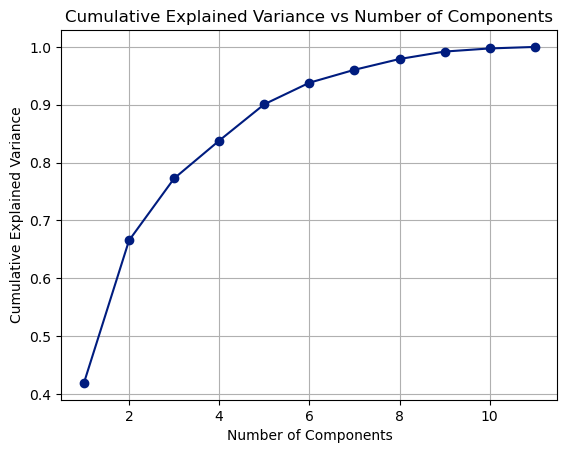

In [155]:
pca = PCA()
X_pca = df_nn.drop("quality", axis=1)
X_pca = pca.fit_transform(X)
explained_var = pca.explained_variance_ratio_
plt.figure()
plt.plot(range(1, len(explained_var) + 1), np.cumsum(explained_var), marker='o')
plt.title("Cumulative Explained Variance vs Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()


Seemingly, the first 6 components explain > 90% of the variability in our dataset. Thus, we can perform dimensionality reduction as follows:

In [156]:
pca6 = PCA(n_components=6)
X_6 = pca6.fit_transform(X)
post_pca_feature_info = dict()
for i in range(6):
    post_pca_feature_info[i] = pca6.components_[i]
df_rest = pd.concat([pd.DataFrame(X_6), pd.DataFrame(df["quality"])], axis=1)
df_rest

0         1         2         3         4         5  quality
0    -0.900003 -0.888539 -0.671833 -1.027988 -0.554067 -1.002369        2
1     0.591288  0.019157 -0.718672 -0.868745  0.662548 -0.511957        2
2     0.180922 -0.388754 -0.399127 -0.760290  0.066545 -0.484459        2
3    -0.409964 -0.273695  2.080465 -0.564549  0.728232  0.747600        3
4    -0.962730 -0.989472 -0.641998 -0.996231 -0.323537 -0.941470        2
...        ...       ...       ...       ...       ...       ...      ...
1013 -0.720236 -0.434652 -0.971810  0.859522  0.505729 -0.399036        3
1014 -1.006771 -0.868062 -0.516893  0.360968  0.690971 -1.286000        3
1015 -0.345467 -1.021495 -1.623651 -0.009500  0.464841  0.172798        2
1016 -1.506499 -0.494817 -1.488401  1.053975  1.095754 -0.577633        3
1017 -0.961047 -0.924274 -1.602621  0.406214  0.612254 -0.823208        2

[1018 rows x 7 columns]

In [157]:
df_rest.to_csv("PCADataset.csv", index=False)

### Saving metadata about the principal components

In [158]:
with open("metadata.txt", "w") as file:
    file.write("Principal Components:\n")
    file.write(str(post_pca_feature_info)+"\n\n")
    file.write("Feature Order:\n")
    file.write(str(df_nn.columns[:-1].to_list()))